In [1]:
%matplotlib inline


# Completado de rostros con estimadores multisalida

Este ejemplo muestra el uso de un estimador multisalida para completar imágenes.
El objetivo es predecir la mitad inferior de un rostro a partir de su mitad superior.

La primera columna de imágenes muestra rostros reales. Las siguientes columnas ilustran cómo los árboles extremadamente aleatorios, los k vecinos más cercanos, la regresión lineal y la regresión de cresta completan la mitad inferior de esos rostros.

In [2]:
# https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_multioutput_face_completion.html

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RANSACRegressor


In [ ]:
# data: Es un array de numpy con las imágenes de rostros del dataset Olivetti Faces. 
# Cada fila representa una imagen (rostro) y cada columna un píxel (4096 columnas = 64x64 píxeles por imagen).

# targets: Es un array con las etiquetas de cada imagen, indicando a qué persona 
# pertenece cada rostro (valores de 0 a 39, para 40 personas distintas).

# Load the faces datasets
data, targets = fetch_olivetti_faces(return_X_y=True)

print(data.shape)
data

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/abc/scikit_learn_data
(400, 4096)


array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
        0.1570248 ],
       [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
        0.15289256],
       [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
        0.15289256],
       ...,
       [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
        0.19008264],
       [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
        0.60330576],
       [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
        0.38429752]], dtype=float32)

In [4]:
print(targets.shape)
targets

(400,)


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [6]:
train = data[targets < 30] # 80% Train on first 30 people
test = data[targets >= 30]  # 20% Test on last 10 people

In [7]:
print(train.shape)
print(test.shape)

(300, 4096)
(100, 4096)


In [8]:
# 📌 Número de muestras de prueba que queremos tomar
n_faces = 5   # queremos 5 caras (o 5 ejemplos) de nuestro dataset de test
print("Cantidad de ejemplos a seleccionar:", n_faces)

# 📌 Generamos un generador de números aleatorios reproducible
rng = check_random_state(5)
print("Objeto generador aleatorio:", rng)

# 📌 Seleccionamos índices aleatorios dentro de test
face_ids = rng.randint(test.shape[0], size=(n_faces,))
print("Cantidad total de filas en test:", test.shape[0])
print("Índices seleccionados aleatoriamente:", face_ids)

# 📌 Subconjunto del dataset de test usando los índices aleatorios
test = test[face_ids, :]
print("Forma del nuevo test después de seleccionar las filas:", test.shape)

# 📌 Mostrar el contenido de esas 5 muestras seleccionadas
print("Contenido de las 5 muestras seleccionadas:\n", test)


Cantidad de ejemplos a seleccionar: 5
Objeto generador aleatorio: RandomState(MT19937)
Cantidad total de filas en test: 100
Índices seleccionados aleatoriamente: [99 78 61 16 73]
Forma del nuevo test después de seleccionar las filas: (5, 4096)
Contenido de las 5 muestras seleccionadas:
 [[0.5165289  0.46280992 0.28099173 ... 0.35950413 0.3553719  0.38429752]
 [0.13636364 0.10743801 0.09090909 ... 0.446281   0.47107437 0.45454547]
 [0.3429752  0.28512397 0.70247936 ... 0.18181819 0.21900827 0.19421488]
 [0.77272725 0.8057851  0.79752064 ... 0.2107438  0.19008264 0.13636364]
 [0.13636364 0.23966943 0.3429752  ... 0.29338843 0.28512397 0.26859504]]


In [10]:
# 📌 Cantidad de columnas (pixeles por imagen)
# Cada fila = una imagen, cada columna = un pixel
n_pixels = data.shape[1]   # Ejemplo: 4096 si la imagen es de 64x64
print("Cantidad total de pixeles por imagen:", n_pixels)

# 📌 PARTE SUPERIOR DE LAS CARAS (features para entrenar)
# [:, : (n_pixels+1)//2] → tomamos las primeras columnas (mitad superior de la imagen)
X_train = train[:, : (n_pixels + 1) // 2]
print("Forma de X_train (mitad superior de las imágenes de entrenamiento):", X_train.shape)

# 📌 PARTE INFERIOR DE LAS CARAS (LO QUE QUEREMOS PREDECIR)
# [:, n_pixels//2 :] → tomamos las columnas restantes (mitad inferior de la imagen)
y_train = train[:, n_pixels // 2 :]
print("Forma de y_train (mitad inferior de las imágenes de entrenamiento):", y_train.shape)

# 📌 Lo mismo para los datos de test
X_test = test[:, : (n_pixels + 1) // 2]
print("Forma de X_test (mitad superior de las imágenes de test):", X_test.shape)

y_test = test[:, n_pixels // 2 :]
print("Forma de y_test (mitad inferior de las imágenes de test):", y_test.shape)


Cantidad total de pixeles por imagen: 4096
Forma de X_train (mitad superior de las imágenes de entrenamiento): (300, 2048)
Forma de y_train (mitad inferior de las imágenes de entrenamiento): (300, 2048)
Forma de X_test (mitad superior de las imágenes de test): (5, 2048)
Forma de y_test (mitad inferior de las imágenes de test): (5, 2048)


In [11]:
# 📌 Definimos un diccionario de modelos (todos son REGRESORES, no clasificadores)
# La idea es entrenar distintos algoritmos de regresión y luego comparar sus resultados.
ESTIMATORS = {
    # 🌲 Extra Trees Regressor
    # - Conjunto de árboles de decisión entrenados de forma aleatoria (tipo Random Forest, pero más aleatorio).
    # - n_estimators=10 → número de árboles en el conjunto
    # - max_features=32 → número máximo de features usados en cada árbol
    # - random_state=0 → asegura reproducibilidad
    "Extra trees": ExtraTreesRegressor(
        n_estimators=10, max_features=32, random_state=0
    ),

    # 👥 K-Nearest Neighbors (KNN) Regressor
    # - Predice el valor de un punto como el promedio de sus vecinos más cercanos.
    "K-nn": KNeighborsRegressor(),

    # 📈 Regresión Lineal
    # - Ajusta una recta (o hiperplano en varias dimensiones).
    # - Supone una relación lineal entre entrada (X) y salida (y).
    "Linear regression": LinearRegression(),

    # 🧾 Ridge Regression (con validación cruzada)
    # - Igual que la regresión lineal pero con regularización (penaliza coeficientes grandes).
    # - Ayuda a evitar sobreajuste.
    "Ridge": RidgeCV(),

    # 🔨 RANSAC (RANdom SAmple Consensus) Regressor
    # - Robusto frente a outliers (valores atípicos).
    # - Ajusta un modelo lineal ignorando los puntos que no encajan bien.
    # - min_samples=200 → mínimo de muestras para ajustar un modelo válido.
    "Robust regression": RANSACRegressor(min_samples=200)
}

# 📌 Mostrar el diccionario de modelos
print("Modelos definidos en ESTIMATORS:")
for nombre, modelo in ESTIMATORS.items():
    print(f"- {nombre}: {modelo}")


Modelos definidos en ESTIMATORS:
- Extra trees: ExtraTreesRegressor(max_features=32, n_estimators=10, random_state=0)
- K-nn: KNeighborsRegressor()
- Linear regression: LinearRegression()
- Ridge: RidgeCV()
- Robust regression: RANSACRegressor(min_samples=200)


In [13]:
# 📌 Creamos un diccionario vacío donde guardaremos las predicciones de cada modelo
y_test_predict = dict()

# 📌 Recorremos todos los modelos definidos en ESTIMATORS
# name = nombre del modelo (ej: "Extra trees", "K-nn", etc.)
# estimator = objeto del regresor correspondiente
for name, estimator in ESTIMATORS.items():
    
    # 1️⃣ ENTRENAMOS el modelo con los datos de entrenamiento
    # X_train = parte superior de las caras
    # y_train = parte inferior de las caras
    estimator.fit(X_train, y_train)
    
    # 2️⃣ HACEMOS PREDICCIONES con los datos de test
    # X_test = parte superior de las caras en el conjunto de test
    # → Queremos predecir cómo sería la parte inferior (y_test)
    y_test_predict[name] = estimator.predict(X_test)

    # 3️⃣ Mostrar qué modelo ya fue entrenado y guardado
    print(f"Modelo entrenado y predicciones guardadas: {name}")

# 📌 Al final, y_test_predict es un diccionario donde:
# - La clave es el nombre del modelo
# - El valor es un array con las predicciones de ese modelo sobre el test
print("\nContenido de y_test_predict (resumen):")
for name, preds in y_test_predict.items():
    print(f"{name}: predicciones con forma {preds.shape}")


Modelo entrenado y predicciones guardadas: Extra trees
Modelo entrenado y predicciones guardadas: K-nn
Modelo entrenado y predicciones guardadas: Linear regression
Modelo entrenado y predicciones guardadas: Ridge
Modelo entrenado y predicciones guardadas: Robust regression

Contenido de y_test_predict (resumen):
Extra trees: predicciones con forma (5, 2048)
K-nn: predicciones con forma (5, 2048)
Linear regression: predicciones con forma (5, 2048)
Ridge: predicciones con forma (5, 2048)
Robust regression: predicciones con forma (5, 2048)


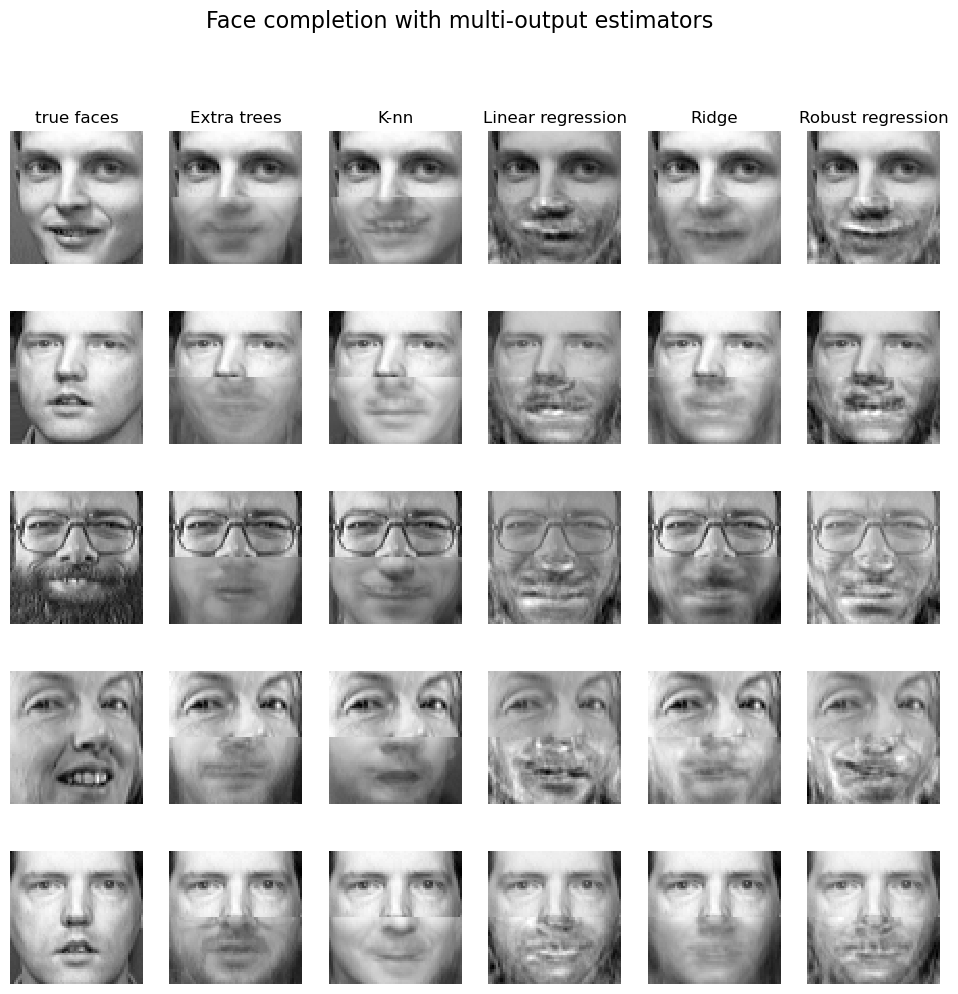

In [14]:
# 📌 Tamaño de cada imagen (caras en 64x64 pixeles)
image_shape = (64, 64)

# 📌 Cantidad de columnas en la grilla de plots
# 1 columna = cara real
# len(ESTIMATORS) columnas = una por cada modelo de regresión
n_cols = 1 + len(ESTIMATORS)

# 📌 Crear la figura general
# figsize se ajusta según número de columnas y filas (n_faces = número de caras a mostrar)
plt.figure(figsize=(2.0 * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with multi-output estimators", size=16)

# 📌 Iteramos sobre cada cara seleccionada en el subconjunto de test
for i in range(n_faces):

    # ✅ Cara real (X_test + y_test = mitad superior + mitad inferior real)
    true_face = np.hstack((X_test[i], y_test[i]))

    # 📌 Primera columna: mostrar la cara verdadera
    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1, title="true faces")

    sub.axis("off")
    sub.imshow(
        true_face.reshape(image_shape),  # reconstruir a 64x64
        cmap=plt.cm.gray,
        interpolation="nearest"
    )

    # 📌 Siguientes columnas: caras reconstruidas por cada regresor
    for j, est in enumerate(sorted(ESTIMATORS)):
        # Reconstruimos la cara juntando la mitad superior real + mitad inferior predicha
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)
        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j, title=est)

        sub.axis("off")
        sub.imshow(
            completed_face.reshape(image_shape),
            cmap=plt.cm.gray,
            interpolation="nearest"
        )

# 📌 Mostrar la grilla completa
plt.show()


Es normal que los resultados no sean perfectos en este ejemplo.
El objetivo es mostrar cómo distintos modelos de regresión pueden predecir la mitad inferior de una cara solo con la mitad superior.
Pero reconstruir imágenes es una tarea difícil:

Los modelos simples (lineales, vecinos, árboles) no capturan toda la complejidad de los rostros humanos.
La información de la mitad superior no siempre es suficiente para adivinar la inferior.
Por eso, las caras generadas pueden verse poco realistas o borrosas.
Este ejemplo sirve para comparar métodos, pero en la práctica se usan modelos más avanzados (como redes neuronales) para tareas de completado de imágenes.